# Computer Modeling of Epidemics with the SIR Model

In this workbook we'll work through a simple model of how an epidemic spreads through a population. The model is called "SIR", because every individual in the population is assigned to one of three compartments:
\begin{align}
S &= \textrm{Susceptible} \\
I &= \textrm{Infected} \\
R &= \textrm{Removed (or Recovered)}
\end{align}

![susceptible -> infected -> removed](images/sir_flow.png)

The number of individuals in each "compartment" of the population changes as the epidemic spreads, according to a set of simple differential equations:

\begin{align}
\frac{dS}{dt} &= -\beta S(t) I(t) \\
\frac{dI}{dt} &= \beta S(t) I(t) - \gamma I(t) \\
\frac{dR}{dt} &= \gamma I(t)
\end{align}

Note that $\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("CSV")
Pkg.add("Optim")
Pkg.add("DifferentialEquations")
using CSV
using Optim
using Plots
using DifferentialEquations

 Activating environment at `/mnt/c/git/ccse/sir/Project.toml`
   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [=====================

Fetching: [========================================>]  100.0 %

  Resolving package versions...
  Installed Parsers ─ v1.0.1
  Installed CSV ───── v0.6.0
   Updating `/mnt/c/git/ccse/sir/Project.toml`
  [336ed68f] + CSV v0.6.0
   Updating `/mnt/c/git/ccse/sir/Manifest.toml`
  [336ed68f] + CSV v0.6.0
  [324d7699] + CategoricalArrays v0.7.7
  [a93c6f00] + DataFrames v0.20.2
  [e2d170a0] + DataValueInterfaces v1.0.0
  [48062228] + FilePathsBase v0.7.0
  [41ab1584] + InvertedIndices v1.0.0
  [682c06a0] + JSON v0.21.0
  [69de0a69] + Parsers v1.0.1
  [2dfb63ee] + PooledArrays v0.5.3
  [bd369af6] + Tables v1.0.3
  [ea10d353] + WeakRefStrings v0.6.2
  [9fa8497b] + Future 
  Resolving package versions...
   Updating `/mnt/c/git/ccse/sir/Project.toml`
 [no changes]
   Updating `/mnt/c/git/ccse/sir/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `/mnt/c/git/ccse/sir/Project.toml`
 [no changes]
   Updating `/mnt/c/git/ccse/sir/Manifest.toml`
 [no changes]
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.

19.40699207164796

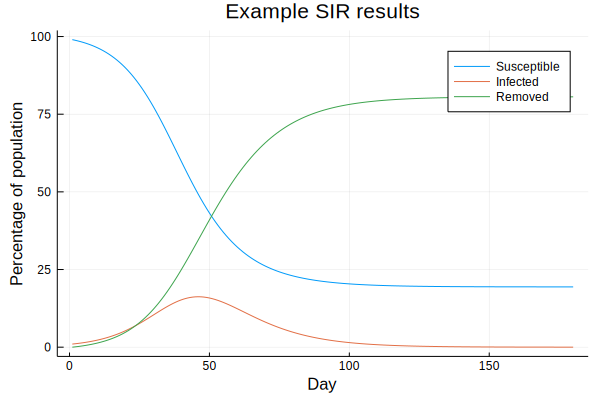

In [28]:
uninfected = 99
infected = 1
n = uninfected + infected

dt = 1.0
lambda = 0.002
gam = 0.1

function update_SIR(current)
    s = current[1]
    i = current[2]
    r = current[3]
    return [s - lambda * s * i * dt, i + lambda * s * i * dt - gam * i * dt, r + gam * i * dt]
end

t_final = 180
n_steps = round(Int64, t_final / dt)
result = Array{Float64}(undef, n_steps+1, 3)
time = 1:n_steps

result[1,:] = [uninfected, infected, 0.0]
for step = time
    new = update_SIR(result[step,:])
    result[step+1,1] = new[1]
    result[step+1,2] = new[2]
    result[step+1,3] = new[3]
end
print(result[n_steps,1])

using Plots
gr()
plot(time, result[1:n_steps,:], title="Example SIR results", xlabel="Day", ylabel="Percentage of population", labels = ["Susceptible" "Infected" "Removed"])

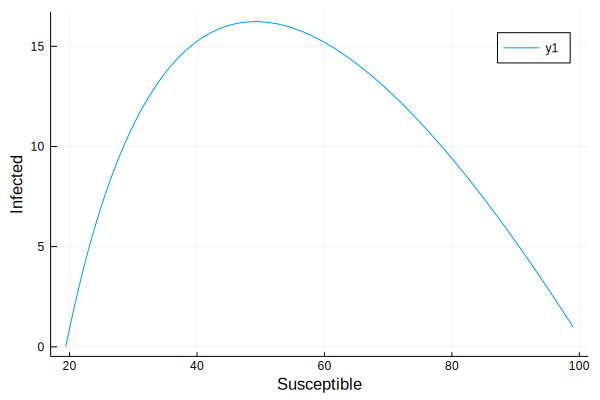

In [29]:
plot(result[:,1], result[:,2], xlabel="Susceptible", ylabel="Infected")

In [38]:
using CSV
x = CSV.read("au_covid.csv", transpose=true)
print(x)

MethodError: MethodError: no method matching Parsers.Options(::Missing, ::UInt8, ::UInt8, ::UInt8, ::UInt8, ::UInt8, ::UInt8, ::UInt8, ::Nothing, ::Nothing, ::Nothing, ::Bool, ::Bool, ::Nothing, ::Bool, ::Bool, ::Bool, ::Bool)
Closest candidates are:
  Parsers.Options(::Union{Missing, Nothing, Array{String,1}}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Nothing, Char, UInt8, String}, ::Union{Char, UInt8}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, String, Dates.DateFormat}, ::Any, ::Any, ::Any, ::Any, ::Any) at /home/milthorpe/.julia/packages/Parsers/GLY4Q/src/Parsers.jl:60
  Parsers.Options(::Union{Missing, Nothing, Array{String,1}}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Nothing, Char, UInt8, String}, ::Union{Char, UInt8}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, String, Dates.DateFormat}, ::Any, ::Any, ::Any, ::Any) at /home/milthorpe/.julia/packages/Parsers/GLY4Q/src/Parsers.jl:60
  Parsers.Options(::Union{Missing, Nothing, Array{String,1}}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Char, UInt8}, ::Union{Nothing, Char, UInt8, String}, ::Union{Char, UInt8}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, Array{String,1}}, ::Union{Nothing, String, Dates.DateFormat}, ::Any, ::Any, ::Any) at /home/milthorpe/.julia/packages/Parsers/GLY4Q/src/Parsers.jl:60

In [5]:
states = convert(Matrix, x)
state_names = reshape(String.(names(x)), 1, :)
plot(states, title="COVID-19 Cases per State/Territory", xlabel="Day", ylabel="Number of cases", labels=state_names, legend=:topleft)

UndefVarError: UndefVarError: x not defined

In [6]:
national=sum(states,dims=2)
plot(national,title="COVID-19 Cases in Australia", xlabel="Day", ylabel="Number of cases", legend=false)

UndefVarError: UndefVarError: states not defined

In [7]:
dt = 1.0
popsize=25000000
lambda = 0.1/popsize
gam = 1.0/21
t_final = size(states,1)
n_steps = round(Int64, t_final / dt)
result = Array{Float64}(undef, n_steps, 3)
time = 1:n_steps
sir = SIR(popsize-100.0,100.0,0.0)
for step = time
    sir = update_SIR(sir)
    result[step,1] = sir.susceptible
    result[step,2] = sir.infected
    result[step,3] = sir.removed
end
print(result[n_steps,1])
predicted=result[:,2]+result[:,3]

plot(time, [national,predicted], title="Actual vs. Observed Cases", xlabel="Day", ylabel="Number of Cases", labels = ["Actual" "Predicted"])

UndefVarError: UndefVarError: states not defined

In [8]:
function SIR!(du,u,p,t)
    S,I,R = u
    β,γ = p
    du[1] = dS = -β*I*S
    du[2] = dI = β*I*S - γ*I
    du[3] = dR = γ*I
end

#t_final=14
#data = [1, 3, 6, 25, 73, 222, 294, 258, 237, 191, 125, 69, 27, 11, 4]
#popsize=762

t_final = size(national,1)
data = national[:]
popsize=25000000

tspan = (0.0,t_final)
u0 = [popsize,1.0,0.0]


function ss(x)
    prob = ODEProblem(SIR!,u0,tspan,(x[1],x[2]))
    sol = solve(prob)
    pred_total_cases = sol(1:t_final)[2,:]+sol(1:t_final)[3,:]
    return(sum((pred_total_cases - data) .^2))
end

opt = optimize(ss,[0.001,0.01],NelderMead())
beta,gamma = opt.minimizer
println("beta = ",beta," gamma = ",gamma)
println(tspan)
prob = ODEProblem(SIR!,u0,tspan,(beta,gamma))
sol = solve(prob)
println(size(sol))
predicted=sol[2,:]
print(sol[:,1:10])
plot(predicted,
    linewidth=2,
    xaxis="Time in days",
    labels=["Susceptible" "Infected" "Removed"])
plot!([1:t_final],data,linestyle=:dash,marker=:circle,markersize=4,label="Data")

UndefVarError: UndefVarError: national not defined